In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F
from torchvision.datasets import SVHN
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

In [4]:
transform_one_channel = transforms.Compose([
                                transforms.CenterCrop((28, 28)),
                                transforms.Grayscale(num_output_channels=1),                              
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,],[0.5,])
                                ])

In [5]:
test_dataset=SVHN(root="E:/git/Door_number_finding_system/data",split='test', download=True, transform=transform_one_channel)
train_dataset=SVHN(root="E:/git/Door_number_finding_system/data", download=True, transform=transform_one_channel)


Using downloaded and verified file: E:/git/Door_number_finding_system/data\test_32x32.mat
E:/git/Door_number_finding_system/data\test_32x32.mat
Using downloaded and verified file: E:/git/Door_number_finding_system/data\train_32x32.mat
E:/git/Door_number_finding_system/data\train_32x32.mat


In [6]:
class Classifier(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
		self.pool = nn.MaxPool2d(2, 2)
		self.dropout1 = nn.Dropout2d(0.25)
		self.dropout2 = nn.Dropout2d(0.5)
		self.fc1 = nn.Linear(64 * 7 * 7, 128)
		self.fc2 = nn.Linear(128, 10)

	def forward(self, x):
		x2=self.conv1(x)
		x1=F.relu(x2)
		x = self.pool(x1)
		x = self.dropout1(x)
		x = self.pool(F.relu(self.conv2(x)))
		x = self.dropout2(x)
		x = x.view(-1, 64 * 7 * 7)
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		return x


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
model = Classifier()

model.to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
         Dropout2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
         MaxPool2d-5             [-1, 64, 7, 7]               0
         Dropout2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
            Linear-8                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.43
Params size (MB): 1.61
Estimated Total Size (MB): 2.04
----------------------------------------------------------------


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
batch_size=100
num_epochs=10

val_size = len(test_dataset)
train_size = len(train_dataset)


train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,pin_memory=True)

In [11]:
losses = []
accuracies = []
val_losses = []
val_accuracies = []

In [12]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        images=images.to(device)
        labels=labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
          
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
        _, predicted = torch.max(outputs.data, 1)
    acc = (predicted == labels).sum().item() / labels.size(0)
    accuracies.append(acc)
    losses.append(loss.item())  
          
    # Evaluate the model on the validation set
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            labels=labels.to(device)
            images=images.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
              
            _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        val_acc += correct / total
        val_accuracies.append(acc)
        val_losses.append(loss.item())  
      
              
    print('Epoch [{}/{}],Loss:{:.4f},Validation Loss:{:.4f},Accuracy:{:.2f},Validation Accuracy:{:.2f}'.format(
        epoch+1, num_epochs, loss.item(), val_loss, acc ,val_acc))

Epoch [1/10],Loss:0.6288,Validation Loss:214.5894,Accuracy:0.79,Validation Accuracy:0.78
Epoch [2/10],Loss:0.3515,Validation Loss:180.6398,Accuracy:0.79,Validation Accuracy:0.91
Epoch [3/10],Loss:0.4308,Validation Loss:166.6588,Accuracy:0.75,Validation Accuracy:0.88
Epoch [4/10],Loss:0.2832,Validation Loss:158.3617,Accuracy:0.84,Validation Accuracy:0.91
Epoch [5/10],Loss:0.4363,Validation Loss:151.5917,Accuracy:0.79,Validation Accuracy:0.84
Epoch [6/10],Loss:0.3916,Validation Loss:148.4041,Accuracy:0.84,Validation Accuracy:0.88
Epoch [7/10],Loss:0.3038,Validation Loss:139.5279,Accuracy:0.93,Validation Accuracy:0.94
Epoch [8/10],Loss:0.3338,Validation Loss:135.2692,Accuracy:0.93,Validation Accuracy:0.91
Epoch [9/10],Loss:0.2614,Validation Loss:135.6517,Accuracy:0.96,Validation Accuracy:0.91
Epoch [10/10],Loss:0.4596,Validation Loss:133.3294,Accuracy:0.81,Validation Accuracy:0.84


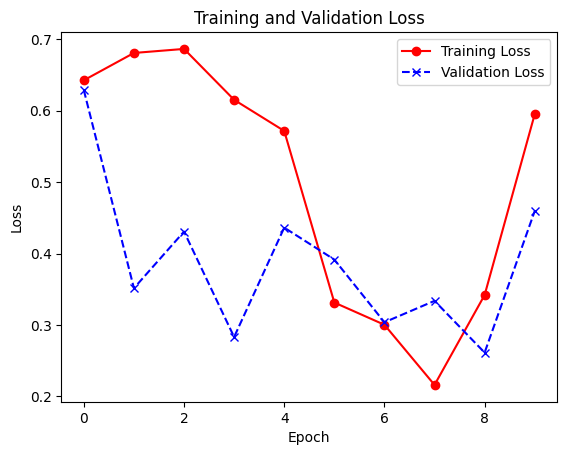

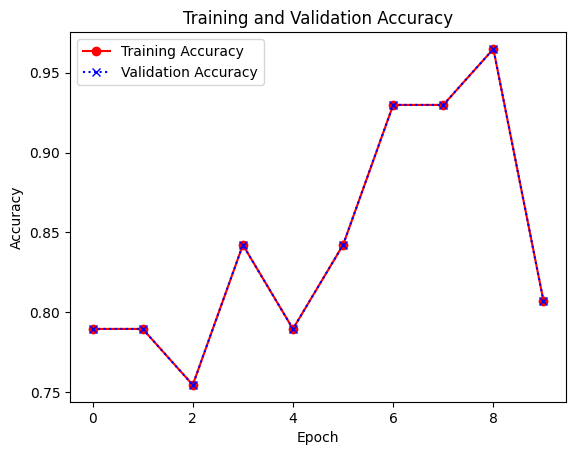

In [16]:
import matplotlib.pyplot as plt

# Plot the training and validation loss over time
plt.plot(range(num_epochs),
		losses, color='red',
		label='Training Loss',
		marker='o')
plt.plot(range(num_epochs),
		val_losses,
		color='blue',
		linestyle='--',
		label='Validation Loss',
		marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over time
plt.plot(range(num_epochs),
		accuracies,
		label='Training Accuracy',
		color='red',
		marker='o')
plt.plot(range(num_epochs),
		val_accuracies,
		label='Validation Accuracy',
		color='blue',
		linestyle=':',
		marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [14]:
model.eval()
  
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted=predicted.to('cpu')
        labels=labels.to('cpu')
        y_true.extend(labels)
        y_pred.extend(predicted)
  
print('Test Accuracy: {}%'.format(100 * correct / total))

Test Accuracy: 88.76382913337432%


In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1744
           1       0.93      0.94      0.93      5099
           2       0.91      0.94      0.92      4149
           3       0.84      0.83      0.84      2882
           4       0.90      0.91      0.90      2523
           5       0.89      0.88      0.88      2384
           6       0.84      0.86      0.85      1977
           7       0.95      0.86      0.90      2019
           8       0.90      0.78      0.84      1660
           9       0.76      0.87      0.81      1595

    accuracy                           0.89     26032
   macro avg       0.88      0.87      0.88     26032
weighted avg       0.89      0.89      0.89     26032

